Goal of this notebook to test several classifiers on the data set with different features 

And beforehand i want to thank Jose Portilla for his magnificent "Python for Data Science and Machine Learning" course on Udemy , which helped me to dive into ML =)

### Let's begin

First of all neccesary imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
%matplotlib inline

Let's read the data from csv file

In [4]:
sms = pd.read_csv('../input/spam.csv', encoding='latin-1')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Now drop "unnamed" columns and rename v1 and v2 to "label" and "message"

In [5]:
sms = sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
sms = sms.rename(columns = {'v1':'label','v2':'message'})

Let's look into our data

In [5]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Intresting that "Sorry, I'll call later" appears only 30 times here =)

Now let's create new feature "message length" and plot it to see if it's of any interest

In [6]:
sms['length'] = sms['message'].apply(len)
sms.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f69284e30b8>,
      dtype=object)

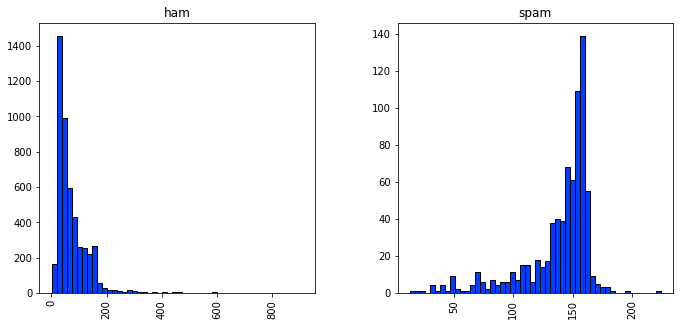

In [7]:
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
sms.hist(column='length', by='label', bins=50,figsize=(11,5))

Looks like the lengthy is the message, more likely it is a spam. Let's not forget this

### Text processing and vectorizing our meddages

Let's create new data frame. We'll need a copy later on

In [8]:
text_feat = sms['message'].copy()

Now define our tex precessing function. It will remove any punctuation and stopwords aswell.

In [9]:
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [61]:
text_feat = text_feat.apply(text_process)
text_feat

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri 2 wkli comp win fa cup final tkts 2...
3                     u dun say earli hor u c alreadi say
4               nah dont think goe usf live around though
5       freemsg hey darl 3 week word back id like fun ...
6           even brother like speak treat like aid patent
7       per request mell mell oru minnaminungint nurun...
8       winner valu network custom select receivea å£9...
9       mobil 11 month u r entitl updat latest colour ...
10      im gonna home soon dont want talk stuff anymor...
11      six chanc win cash 100 20000 pound txt csh11 s...
12      urgent 1 week free membership å£100000 prize j...
13      ive search right word thank breather promis wo...
14                                            date sunday
15      xxxmobilemovieclub use credit click wap link n...
16                                           oh kim watch
17      eh u r

In [11]:
vectorizer = TfidfVectorizer("english")

In [42]:
features = vectorizer.fit_transform(text_feat)

<5572x8037 sparse matrix of type '<class 'numpy.float64'>'
	with 46982 stored elements in Compressed Sparse Row format>

###  Classifiers and predictions

First of all let's split our features to test and train set

In [13]:
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)

Now let's import bunch of classifiers, initialize them and make a dictionary to itereate through

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

In [15]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

Parametres are based on notebook:
[Spam detection Classifiers hyperparameter tuning][1]


  [1]: https://www.kaggle.com/muzzzdy/d/uciml/sms-spam-collection-dataset/spam-detection-classifiers-hyperparameter-tuning/

In [16]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

Let's make functions to fit our classifiers and make predictions

In [17]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)

In [18]:
def predict_labels(clf, features):
    return (clf.predict(features))

Now iterate through classifiers and save the results

In [19]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

In [20]:
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df

/home/codemantra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


,Score
SVC,0.978469
KN,0.924641
NB,0.984450
DT,0.958732
LR,0.943182
RF,0.970096
AdaBoost,0.967105
BgC,0.967105
ETC,0.977273


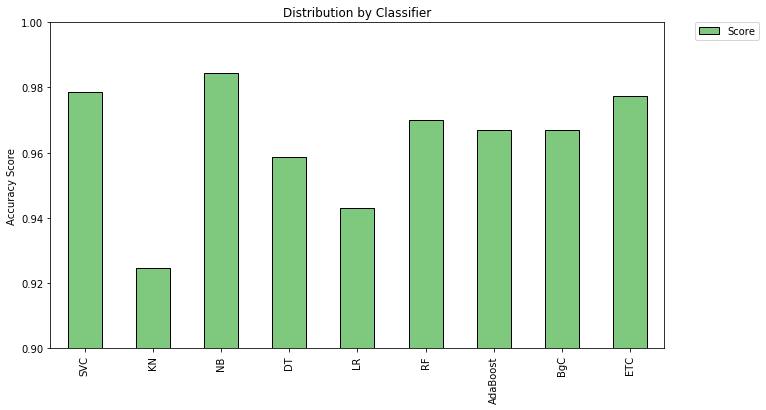

In [21]:
df.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Looks like ensemble classifiers are not doing as good as expected.

### Stemmer

It is said that stemming short messages does no goot or even harm predictions. Let's try this out.

Define our stemmer function

In [22]:
def stemmer (text):
    text = text.split()
    words = ""
    for i in text:
            stemmer = SnowballStemmer("english")
            words += (stemmer.stem(i))+" "
    return words

Stem, split, fit - repeat... Predict!

In [23]:
text_feat = text_feat.apply(stemmer)

In [24]:
features = vectorizer.fit_transform(text_feat)

In [25]:
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)

In [26]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

In [27]:
df2 = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score2'])
df = pd.concat([df,df2],axis=1)
df

/home/codemantra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


,Score,Score2
SVC,0.978469,0.978469
KN,0.924641,0.928230
NB,0.984450,0.985048
DT,0.958732,0.959928
LR,0.943182,0.946770
RF,0.970096,0.974880
AdaBoost,0.967105,0.970096
BgC,0.967105,0.968900
ETC,0.977273,0.977871


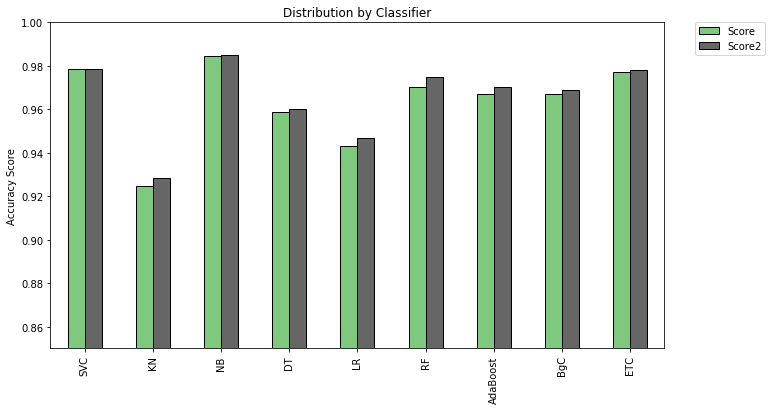

In [28]:
df.plot(kind='bar', ylim=(0.85,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Looks like mostly the same . Ensemble classifiers doing a little bit better, NB still got the lead.

### What have we forgotten? Message length!

Let's append our message length feature to the matrix we fit into our classifiers

In [29]:
lf = sms['length'].as_matrix()
newfeat = np.hstack((features.todense(),lf[:, None]))

/home/codemantra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [30]:
features_train, features_test, labels_train, labels_test = train_test_split(newfeat, sms['label'], test_size=0.3, random_state=111)

In [34]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

In [60]:
df3 = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score3'])
df = pd.concat([df,df3],axis=1)
df

/home/codemantra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


,Score,Score2,Score3
SVC,0.978469,0.978469,0.861244
KN,0.924641,0.928230,0.880383
NB,0.984450,0.985048,0.982656
DT,0.958732,0.959928,0.957536
LR,0.943182,0.946770,0.954545
RF,0.970096,0.974880,0.975478
AdaBoost,0.967105,0.970096,0.961722
BgC,0.967105,0.968900,0.962321
ETC,0.977273,0.977871,0.975478


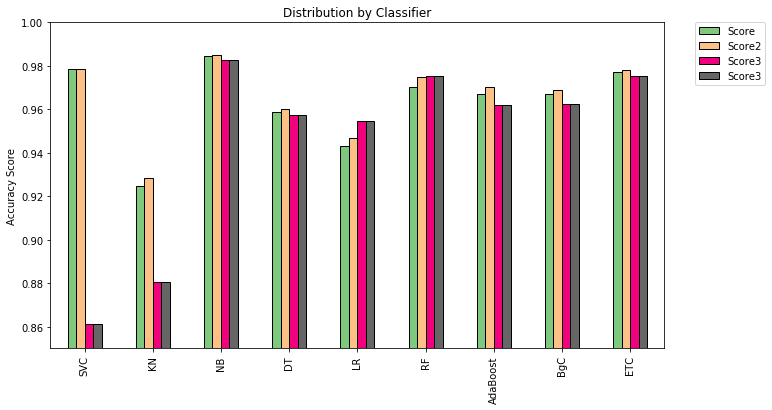

In [36]:
df.plot(kind='bar', ylim=(0.85,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

This time everyone are doing a little bit worse, except for LinearRegression and RandomForest. But the winner is still MultinominalNaiveBayes.

### Voting classifier

We are using ensemble algorithms here, but what about ensemble of ensembles? Will it beat NB?

In [37]:
from sklearn.ensemble import VotingClassifier

In [38]:
eclf = VotingClassifier(estimators=[('BgC', bc), ('ETC', etc), ('RF', rfc), ('Ada', abc)], voting='soft')

In [39]:
eclf.fit(features_train,labels_train)

VotingClassifier(estimators=[('BgC', BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=9, n_jobs=None, oob_score=False, random_state=111,
         verbose=0, warm_start=False)), ('ETC', ExtraTreesClassifier(bootstrap=Fal...hm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=62, random_state=111))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [40]:
pred = eclf.predict(features_test)

In [41]:
print(accuracy_score(labels_test,pred))

0.979066985645933


Better but nope.

### Final verdict - well tuned NaiveBayes is your friend in spam detection.